# Denoising Autoencoder and Optimization Methods 

### Autoencoders

Autoencoders are unsupervised learning approaches used to extract useful information from data. For example, they can be used for pretraining of data for a classification task to increase performance. Traditionally, an encoder is a deterministic function, $\mathbf{y} = f(\mathbf{x})$, that maps $\mathbf{x}$ to $\mathbf{y}$. An decoder is a deterministic function, $\mathbf{z} = g(\mathbf{y})$, that maps $\mathbf{y}$ to $\mathbf{z}$, where $\mathbf{z}$ is typically the mean of distribution that is considered to generate $\mathbf{x}$ in high probability.

If the dimension of $\mathbf{y}$, $d'$, is less than the dimension of $\mathbf{x}$, $d$, the autoencoder is called an under-complete autoencoder. On the other hand, if $d'$ is greater than $d$, it is an overcomplete autoencoder. In most cases, traditionally, an under-complete autoencoder is used for dimension reduction.

Recently, encoders and decoders are generalized to stochastic mappings $p_{enc}(\mathbf{y}|\mathbf{x})$ and $p_{dec}(\mathbf{x}|\mathbf{y})$ rather than deterministic functions. The aim is to prevent learning identity function and learn useful features for the task in hand.

The general form of an autoencoder is using an affirm transformation on the data and adding nonlinearity. The reconstruction form is similar, applying an affine transformation and adding nonlinearity. 

\begin{align} 
\mathbf{y} &= f(\mathbf{x}) = s(\mathbf{W}\mathbf{x}+\mathbf{b}) \\ 
\mathbf{z} &= g(\mathbf{y}) = s(\mathbf{W'}\mathbf{y}+\mathbf{b'})
\end{align}
$s(.)$ is a nonlinear function like a sigmoid or tanh. If the nonlinearity is not introduced and loss function is squared loss error, the model would be principal component analysis (PCA).

## Denoising Autoencoder 

Denoising autoencoders aim to reconstruct the original data from the noisy version of the data. The idea is to extract useful features while reconstructing the input from its corrupted version. A schematic representation is given in the following Figure. $\mathbf{x}^-$  denotes the corrupted version of $\mathbf{x}$.

<img src="DAE_eng.png" width="600">
 
\begin{align*}
\mathbf{y} &= f(\mathbf{x}^-) \text{ :$f \rightarrow$ encoder function} \\
\mathbf{z} &= g(\mathbf{y}) \text{ :$g \rightarrow$ decoder function} \\
\mathcal{L}(\mathbf{x},\mathbf{z}) &\sim - \log p(\mathbf{x}|\mathbf{z})
\end{align*}

Three types of noise are introduced for the input corruption. The first alternative is that an isotropic Gaussian noise can be added to the input, $\mathbf{x}^- | \mathbf{x} \sim \mathcal{N}(\mathbf{x}, \sigma^2\mathbf{I})$. The second alternative is to set randomly chosen elements of $\mathbf{x}$ to $0$, masking noise, with a given fraction $\gamma$. The third alternative is salt-and-pepper noise. In this case, randomly chosen elements of $\mathbf{x}$, again with a fraction of $\gamma$, is set to maximum or minimum value according to a fair coin. For example, $0$ or $1$.

The objective is to maximize the likelihood of reconstructing the input, given the representation. The likelihood $ p(\mathbf{x}|\mathbf{z})$, can be chosen according to the input: 

If $\mathbf{x} \in \mathcal{R}^d$, that is $X|\mathbf{z} \sim \mathcal{N}(\mathbf{z},\sigma^2\mathbf{I})$, $\mathcal{L}(\mathbf{x},\mathbf{z}) $: Objective function to minimize is  $ \mathcal{L}(\mathbf{x},\mathbf{z})  \sim \parallel\mathbf{x}-\mathbf{z}\parallel ^2$, which is the squared error objective. 

If  $\mathbf{x}$ is binary, $\mathbf{x} \in  \{0,1\}^d$, that is $X|\mathbf{z} \sim \mathcal{B}(\mathbf{z})$:  $\mathbf{z}$ should also be in $ [0,1]^d $ , so using a sigmoid function for activation is appropriate. Cross-entrophy loss is the objective to minimize.

\begin{align}
\mathcal{L}(\mathbf{x},\mathbf{z})  = - \sum_j [\mathbf{x}_j\log(\mathbf{z}_j)+(1-\mathbf{x}_j)\log(1-\mathbf{z}_j)]
\end{align}

Geometric interpretation of DAEs is learning a lower dimensional nonlinear manifold. The corrupted values would be farther to the manifold and the stochastic operator will learn to map them on the manifold.  

### Implementation of DAE

Below is an implementation of Denoising Autoencoder. Different parameter update algorithms are also implemented. The explanation is given in the following section.


In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import scipy.io as sio
import numpy as np
import time

import matplotlib.pyplot as plt
import copy

In [19]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')

In [20]:
class DAE_encoder(nn.Module):
    def __init__(self, S, Y):
        super(DAE_encoder, self).__init__()
        self.linear = torch.nn.Linear(S,Y)  
        
    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x
        
 
class DAE_decoder(nn.Module):
    def __init__(self, S, Y, binary):
        super(DAE_decoder, self).__init__()
        self.linear = torch.nn.Linear(Y,S)
        self.binary = binary  
        
    def forward(self, x):
        x = self.linear(x)
        if (self.binary==1):
            x = torch.sigmoid(x)
        return x

In [21]:
def corrupt_input(x, noise_type, noise_level):
    shape= x.shape
    noise = torch.ones(shape)*(1-noise_level)
    
    if (noise_type == "gaussian"):
        corruption_tensor = torch.zeros(shape)
        corruption_tensor = torch.normal(corruption_tensor, corruption_tensor+noise_level)
        return torch.add(x, corruption_tensor)    
    
    corruption_tensor = torch.bernoulli(noise)
    if (noise_type == "mask"):        
        return torch.mul(x, corruption_tensor)
    else: #salt and pepper
        flip_tensor = torch.bernoulli(torch.ones(shape)*0.5)
        corruption_tensor[corruption_tensor==0] = flip_tensor[corruption_tensor==0]
        return torch.mul(x, corruption_tensor)

In [22]:
class denoisingAutoEncoder(nn.Module):
    def __init__(self,input_dim = 50, hidden_sz=10, is_decoder_binary=0, noise_type="mask", noise_level=0.3, 
                         list_of_optims=[{"name":"sgd", "learning_rate":6.0, "color": 'g--'}], epoch=500, shuffle=False, mini_batch_size=100):
        
        super(self.__class__, self).__init__()
    
    ############  DATA PREPARATION
        self.input_dim = input_dim
        self.hidden_sz = hidden_sz
        
#        K = hidden_sz    

        self.noise_type = noise_type
        self.noise_level = noise_level
        self.shuffle = shuffle
        self.mini_batch_size = mini_batch_size
        self.is_decoder_binary = is_decoder_binary            
        self.epoch = epoch
    
####################################
        
        self.encoder_lst = []
        self.decoder_lst = []

        self.encoder = DAE_encoder(self.input_dim, self.hidden_sz)
        self.decoder = DAE_decoder(self.input_dim, self.hidden_sz, self.is_decoder_binary)
        
        self.encoder_lst.append(self.encoder)
        self.decoder_lst.append(self.decoder)
        
        self.main = nn.Sequential(
                self.encoder,
                self.decoder)   

        if self.decoder.binary==0:
            self.Loss = torch.nn.MSELoss(size_average=True)
    
        if list_of_optims!=[]:
            self.copy_of_encoder = copy.deepcopy(self.encoder)
            self.copy_of_decoder = copy.deepcopy(self.decoder)
        else:
            print("Optimization Update Rule is not set!!!")
            return
    
    def corr_input(self, X):
        
        X_cor = Variable(torch.ones(X.shape), )
        X_cor.data[:,0:self.input_dim] = corrupt_input(X.data[:,0:self.input_dim], self.noise_type, self.noise_level)
        
        if self.shuffle ==1:
            perm = torch.randperm(self.batch_size)
            X.data = X.data[perm]
            X_cor.data = X_cor.data[perm]
            
        return X_cor
        
    def Loss_fnc(self, x_hat,x):        
        if self.decoder.binary==0:
            Loss = torch.mean((x_hat-x).t()**2)
            
        else:
            Loss = torch.mean((-x*torch.log(x_hat)-(1-x)*torch.log(1-x_hat)).t())
         
        return Loss  
        
    def forward(self,X_):
        x_hat = self.encoder(X_)
        x_hat = self.decoder(x_hat)
        return x_hat
    
    def train(self,X_, list_of_optims):
        
        X = Variable(torch.ones(X_.shape[0],self.input_dim), )
        X.data[:,0:self.input_dim] = torch.from_numpy(X_).long()         
        self.X = X        
        self.X_cor = self.corr_input(X)
        self.batch_size = X_.shape[0]
        
        cnt=-1
        for opt in list_of_optims:
            cnt+=1
            loss_history = torch.zeros(self.epoch)
            self.encoder = copy.deepcopy(self.copy_of_encoder)
            self.decoder = copy.deepcopy(self.copy_of_decoder)
            
            self.encoder_lst.append(self.encoder)
            self.decoder_lst.append(self.decoder)
            
            param_list = (list(self.encoder.parameters()),list(self.decoder.parameters()))            
    
            v = []
            Epsilon = 10e-8
                
            if opt["name"]=="sgd":
                learning_rate = opt["learning_rate"]           
    
            if opt["name"]=="momentum":
                learning_rate = opt["learning_rate"]
                rho = opt["rho"]
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        v.append(torch.zeros(param_list[i][j].shape))
                
            if opt["name"]=="nesterov":
                learning_rate = opt["learning_rate"]
                rho = opt["rho"]
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        v.append(torch.zeros(param_list[i][j].shape))
    
            if opt["name"]=="adagrad":
                learning_rate = opt["learning_rate"]
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        v.append(torch.zeros(param_list[i][j].shape))
    
            if opt["name"]=="rmsprop":
                learning_rate = opt["learning_rate"]
                decay_rate = opt["decay_rate"]
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        v.append(torch.zeros(param_list[i][j].shape))
    
            if opt["name"]=="adam":
                alpha = opt["alpha"]
                Beta_1 = opt["Beta_1"]
                Beta_2 = opt["Beta_2"]
                Epsilon = 10e-8
                m = []
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        v.append(torch.zeros(param_list[i][j].shape))
                        m.append(torch.zeros(param_list[i][j].shape))
                 
            if opt["name"]=="adadelta": 
                decay_rate = opt["decay_rate"]
                rms_g = []
                rms_dt = []
                dtheta = []   
                for i in range(len(param_list)):
                    for j in range(len(param_list[i])):  
                        rms_g.append(torch.zeros(param_list[i][j].shape))
                        rms_dt.append(torch.zeros(param_list[i][j].shape))
                        dtheta.append(torch.zeros(param_list[i][j].shape))
            
            for e in range(self.epoch):
                mn_batch_num = int(np.ceil(self.batch_size/self.mini_batch_size))
                mini_batch_size = self.mini_batch_size
                loss_hst = 0
                for i in range(mn_batch_num):
                    x_cor = self.X_cor[i*mini_batch_size:min((i+1)*mini_batch_size,self.batch_size)]
                    x = self.X[i*mini_batch_size:(i+1)*mini_batch_size]
        
            
        ###### FORWARD
                    x_hat = self.forward(x_cor)
    
    
                    Loss = self.Loss_fnc(x_hat, x)
                    Loss.backward()
                    loss_hst += Loss.data.item()

    
        ### VANILLA SGD         
                    if opt["name"]=="sgd":
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                param_list[i][j].data.add_(-learning_rate*param_list[i][j].grad.data)   
     
    #    ### SGD WITH MOMENTUM  
    #             #### Sebastian Ruder An overview of gradient descent optimization algorithms∗ 
    #             #####  https://arxiv.org/abs/1609.04747
                    if opt["name"]=="momentum":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                v[t] = rho*v[t] + learning_rate*param_list[i][j].grad.data
                                param_list[i][j].data.add_(-v[t])
                                t= t+1
    
                                
                                
    #    ### SGD WITH NESTEROV        
    #    #### Stanford CS231N 2017 Lecture Slides                            
                    if opt["name"]=="nesterov":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                old_v = v[t]
                                v[t] = rho*v[t] - learning_rate*param_list[i][j].grad.data
                                param_list[i][j].data.add_(-rho*old_v+(1+rho)*v[t])
                                t= t+1
    
    
    #    ##### ADAGRAD       
    #    #### Stanford CS231N 2017 Lecture Slides        
                    if opt["name"]=="adagrad":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                v[t] += param_list[i][j].grad.data**2
                                param_list[i][j].data.add_(-learning_rate*param_list[i][j].grad.data/(v[t]**0.5+1e-7))
                                t= t+1        
            
        #    ##### RMSPROP
            #    #        #### Stanford CS231N 2017 Lecture Slides   
                    if opt["name"]=="rmsprop":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                v[t] = decay_rate*v[t] + (1-decay_rate)* param_list[i][j].grad.data**2
                                param_list[i][j].data.add_(-learning_rate*param_list[i][j].grad.data/(v[t]**0.5+1e-7))
                                t= t+1    
            
    
        #    #### ADAM
        #     ######   ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION  Paper- Diederik P. Kingma, Jimmy Lei Ba
    
                    if opt["name"]=="adam":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                m[t] = torch.ones(shape)*Beta_1*m[t]+(1-Beta_1)*param_list[i][j].grad.data
                                v[t] = torch.ones(shape)*Beta_2*v[t]+(1-Beta_2)*param_list[i][j].grad.data**2
                                alpha_t = alpha*(1-Beta_2**(e+1))**0.5/(1-Beta_1**(e+1))
                                param_list[i][j].data.add_(-alpha_t*m[t]/(v[t]**0.5+Epsilon))
                                t = t+1
    
    
        #    ######   ADADELTA
                    if opt["name"]=="adadelta":
                        t = 0
                        for i in range(len(param_list)):
                            for j in range(len(param_list[i])):
                                shape = param_list[i][j].shape
                                rms_g[t] = decay_rate * rms_g[t] + (1-decay_rate)* param_list[i][j].grad.data**2
                                dtheta[t] = -((rms_dt[t]+Epsilon)**0.5 / (rms_g[t] +Epsilon)**0.5)*param_list[i][j].grad.data           
                                param_list[i][j].data.add_(dtheta[t])
                                rms_dt[t] = decay_rate*rms_dt[t] + (1-decay_rate)*dtheta[t]**2
                                t= t+1    
        #                    
            #### Sebastian Ruder An overview of gradient descent optimization algorithms∗ 
            #####  https://arxiv.org/abs/1609.04747 
    
    
            
    ###########   DELETE GRAD VALUES        
                    for i in range(len(param_list)):
                        for j in range(len(param_list[i])):
                            param_list[i][j].grad.data.zero_()  
                            
                loss_history[e] = loss_hst/mn_batch_num
                    
            opt["loss_history"] = loss_history
            opt["encoder"] = self.encoder
            opt["decoder"] = self.decoder
                            
        self.list_of_optims = list_of_optims
    
    def plot_loss_histories(self, start=0, end = -1):
        plt.figure(figsize=(15,10))
        for opt in self.list_of_optims:
            if opt["name"]=="sgd":
                plt.plot(np.asarray(opt["loss_history"][start:end]),opt["color"], label="VANILLA SGD LR="+str(opt["learning_rate"]),linewidth=2.0)       
        
            if opt["name"]=="momentum":
                plt.plot(np.asarray(opt["loss_history"][start:end]), opt["color"], label="SGD WITH MOMENTUM LR="+str(opt["learning_rate"]),linewidth=3.0)
                
            if opt["name"]=="nesterov":
                plt.plot(np.asarray(opt["loss_history"][start:end]),opt["color"], label="NESTEROV SGD LR="+str(opt["learning_rate"]),linewidth=2.0)
        
            if opt["name"]=="adagrad":
                plt.plot(np.asarray(opt["loss_history"][start:end]),opt["color"], label="ADAGRAD LR="+str(opt["learning_rate"]),linewidth=2.0)
        
            if opt["name"]=="rmsprop":
                plt.plot(np.asarray(opt["loss_history"][start:end]),opt["color"], label="RMSPROP LR="+str(opt["learning_rate"]),linewidth=2.0)
        
            if opt["name"]=="adam":
                plt.plot(np.asarray(opt["loss_history"][start:end]),opt["color"], label="ADAM",linewidth=2.0)
                 
            if opt["name"]=="adadelta": 
                plt.plot(np.asarray(opt["loss_history"][start:end]),color = opt["color"], label="ADADELTA",linewidth=2.0)
        
        plt.legend(prop={'size': 20})
        

## Comparison of Stochastic Optimization Algorithms

In this section, Here are some commonly used stochastic optimization update algorithms to train an ANN. 

$\theta$ : Parameters 

$\alpha$ : Learning Rate 

$\gamma$ : Decaying Rate

$\rho$ : Momentum 

$\triangledown_\theta \mathcal{L}(\theta_{t-1}) $ or $g_t$: Gradient of Loss Function at time $t$ wrt parameters at time step $t-1$

### Stochastic Gradient Descent (SGD)
The parameters are updated in the opposite direction of the gradient with the ratio of learning rate. The update can be done for each input data or can be done in mini batches. The update is calculated for the size of a mini batch and it is averaged. 

\begin{align}
\theta_{t} &= \theta_{t-1} - \alpha g_t
\end{align}

### SGD with Momentum
When the rate of change along the different dimensions differ, SGD becomes very slow to converge. Momentum term allows to make bigger moves when the rate of change is high and smaller moves when the rate of change is smaller.

\begin{align}
v_{t} &= \rho v_{t-1} + \alpha g_t \\
\theta_{t} &= \theta_{t-1} - v_t
\end{align}

[Sebastian Ruder An overview of gradient descent optimization algorithms∗ 
https://arxiv.org/abs/1609.04747 ]

### Nesterov accelerated gradient (Nesterov Momentum)

In normal momentum update, we take the previous step into account and add the current gradient to make the update. In Nesterov update, we predict to next move according to the momentum and take the derivative on the expected next positition:

\begin{align}
v_{t} &= \rho v_{t-1} - \alpha \triangledown \mathcal{L}(\theta_{t-1}+\rho v_{t-1} ) \\
\theta_{t} &= \theta_{t-1} + v_t
\end{align}

However it is not feasible to compute the gradient for the next expected state. The update in terms of the current gradient is preferred for the sake of computation simplicity. So, with change of variables:

\begin{align}
\theta_{t} &= \theta_{t-1} + \rho v_{t-1} \\
v_{t} &= \rho v_{t-1} - \alpha g_t \\
\theta_{t} &= \theta_{t-1} - \rho v_{t-1} + (1+\rho)  v_t
\end{align}

[Stanford CS231N 2017 Lecture Slides]

## Adaptive Methods

Adaptive methods update each parameter according their tendency. 

### ADAGRAD

Adagrad updates the parameter with a proportion of the learning rate according to the parameter's previous gradient behaviour. The sum of the previous gradients' square divides learning rate. That is dimensions with high gradient are updated with a smaller rate of the current gradient value. And vice versa, low gradient update behaviour leads to a faster movement. $\epsilon$ is a small number, like 1e-6, to prevent division by zero. 

\begin{align}
G_t &= \sum_{i=1}^t g_i^2 \\
\theta_{t} &= \theta_{t-1}  - \frac{\alpha}{\sqrt{G_t+\epsilon}} g_t
\end{align}

[Stanford CS231N 2017 Lecture Slides]   

### RMSPROP
RMSProp is weight decay update version of ADAGRAD. In this case the square of the gradient and average of the sum of the squares are taken into consideration instead of the gradient. $\gamma$ is typically [0.9, 0.99, 0.999] 

\begin{align}
G_0 &= 0 \\
G_t &= \gamma G_{t-1} + (1-\gamma) g_t^2\\
\theta_{t} &= \theta_{t-1}  - \frac{\alpha}{\sqrt{G_t+\epsilon}} g_t
\end{align}

[Stanford CS231N 2017 Lecture Slides]    

### Adam

Adam is like a momentum version of RMSProp. $v_t$ term is similar to RMSProp. In additon, decaying average of the past the gradients is used instead of the gradient. $\beta_1$ and $\beta_2$ are typically set to 0.9 and 0.999.

\begin{align}
m_{t} &= \beta_{1}m_{t-1} + (1-\beta_{1})g_t\\
v_{t} &= \beta_{2}v_{t-1} + (1-\beta_{2})g_t^2\\
\alpha_t &= \alpha \frac{\sqrt{1-\beta^t_2}}{1-\beta^t_1} \\
\theta_{t} &= \theta_{t-1} - \alpha_t \frac{m_t}{\sqrt{v_t}+\epsilon}
\end{align}

[ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION  Paper- Diederik P. Kingma, Jimmy Lei Ba]

### AdaDelta

"Adadelta [6] is an extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate. Instead of accumulating all past squared gradients, Adadelta restricts the window of accumulated past gradients to some fixed size w." 

\begin{align}
RMS[g]_t &= \gamma RMS[g]_{t-1} + (1-\gamma) g_t^2 \\
\triangledown \theta_t &= -\frac{RMS[\triangledown \theta]_{t-1}}{RMS[g]_t} g_t \\
\theta_t &= \theta_{t-1} + \triangledown \theta_{t} \\
RMS[\triangledown \theta]_t &= \gamma RMS[\triangledown \theta]_{t-1} + (1-\gamma) \triangledown \theta_t^2 \\
\end{align}

[Sebastian Ruder An overview of gradient descent optimization algorithms∗ 
https://arxiv.org/abs/1609.04747 ]

Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. Retrieved from http://arxiv.org/abs/1212.5701 

### Toy Example

Here is a toy example of $N$ vectors of size $S$, drawn from binomial distribution. That is our input is $S$ sized vectors and our dataset contains $N$ data. Our aim is to learn to decode the inputs in $K$ dimensions. 

In [23]:
torch.manual_seed(999)

S = 50
K = 7
N = 60

noise_level =0.3
noise_type = "mask"
epoch = 1000
batch_size = 10
shuffle = 0
is_decoder_binary=1


X_ = np.random.binomial(1,0.2,(N,S))
print(X_)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]
 [0 1 1 ... 1 1 0]]


Parameter example is given below for each optimization algorithm. The required methods can be compared as shown below. 

In [24]:
sgd = {
        "name":"sgd",
        "learning_rate":9.0,
        "color": 'g--'}

sgd1 = {
        "name":"sgd",
        "learning_rate":10,
        "color": 'r--'}

sgd2 = {
        "name":"sgd",
        "learning_rate":8,
        "color": 'b--'}

sgd3 = {
        "name":"sgd",
        "learning_rate":5,
        "color": 'y--'}

momentum = {
        "name":"momentum",
        "learning_rate":0.3,
        "rho":0.9,
        "color": 'r--'}

nesterov = {
        "name":"nesterov",
        "learning_rate":0.4,
        "rho":0.9,
        "color": 'y'}

adagrad = {
        "name":"adagrad",
        "learning_rate":0.4,
        "color": 'g'}

adagrad2 = {
        "name":"adagrad",
        "learning_rate":0.1,
        "color": 'r'}

adagrad3 = {
        "name":"adagrad",
        "learning_rate":0.8,
        "color": 'b'}

rmsprop = {
        "name":"rmsprop",
        "learning_rate":0.005,
        "decay_rate":0.9,
        "color": 'c'}

adam = {
        "name":"adam",
        "alpha":0.001,
        "Beta_1":0.9,
        "Beta_2":0.999,
        "color": 'k'}

adadelta = {
        "name":"adadelta",
        "decay_rate":0.9,
        "color": (0.9, 0.5, 0.1)}

list_of_optims = []

list_of_optims.append(sgd)
list_of_optims.append(sgd1)
list_of_optims.append(sgd2)
list_of_optims.append(sgd3)


list_of_optims.append(momentum)
list_of_optims.append(nesterov)
list_of_optims.append(adagrad)
list_of_optims.append(rmsprop)
list_of_optims.append(adam)
list_of_optims.append(adadelta)

dae = denoisingAutoEncoder(input_dim = S, hidden_sz = K, 
                                                 is_decoder_binary = is_decoder_binary, 
                                                 noise_type = noise_type, noise_level = noise_level, 
                                                 list_of_optims = list_of_optims, epoch = epoch, 
                                                 shuffle = shuffle, mini_batch_size = batch_size)

dae.train(X_,list_of_optims)

Training completed


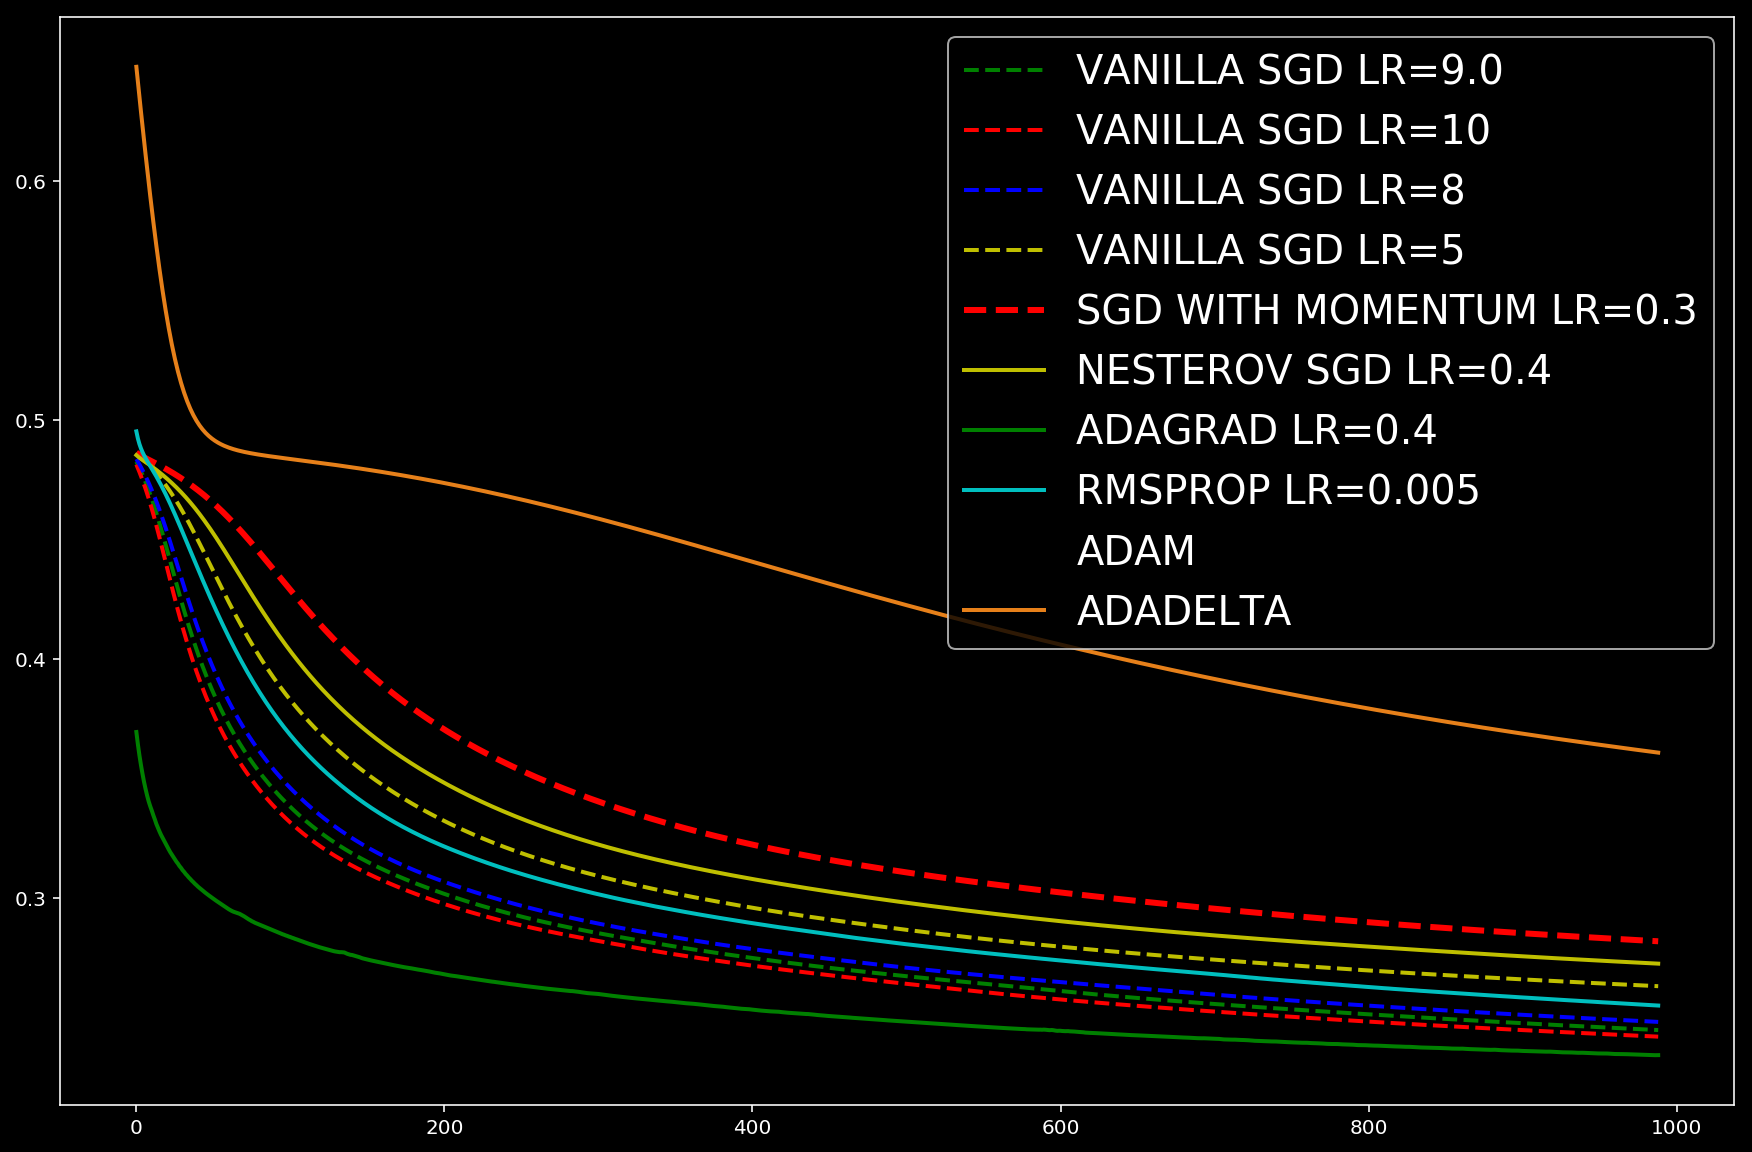

In [25]:
dae.plot_loss_histories(10,-1)

print("Training completed")

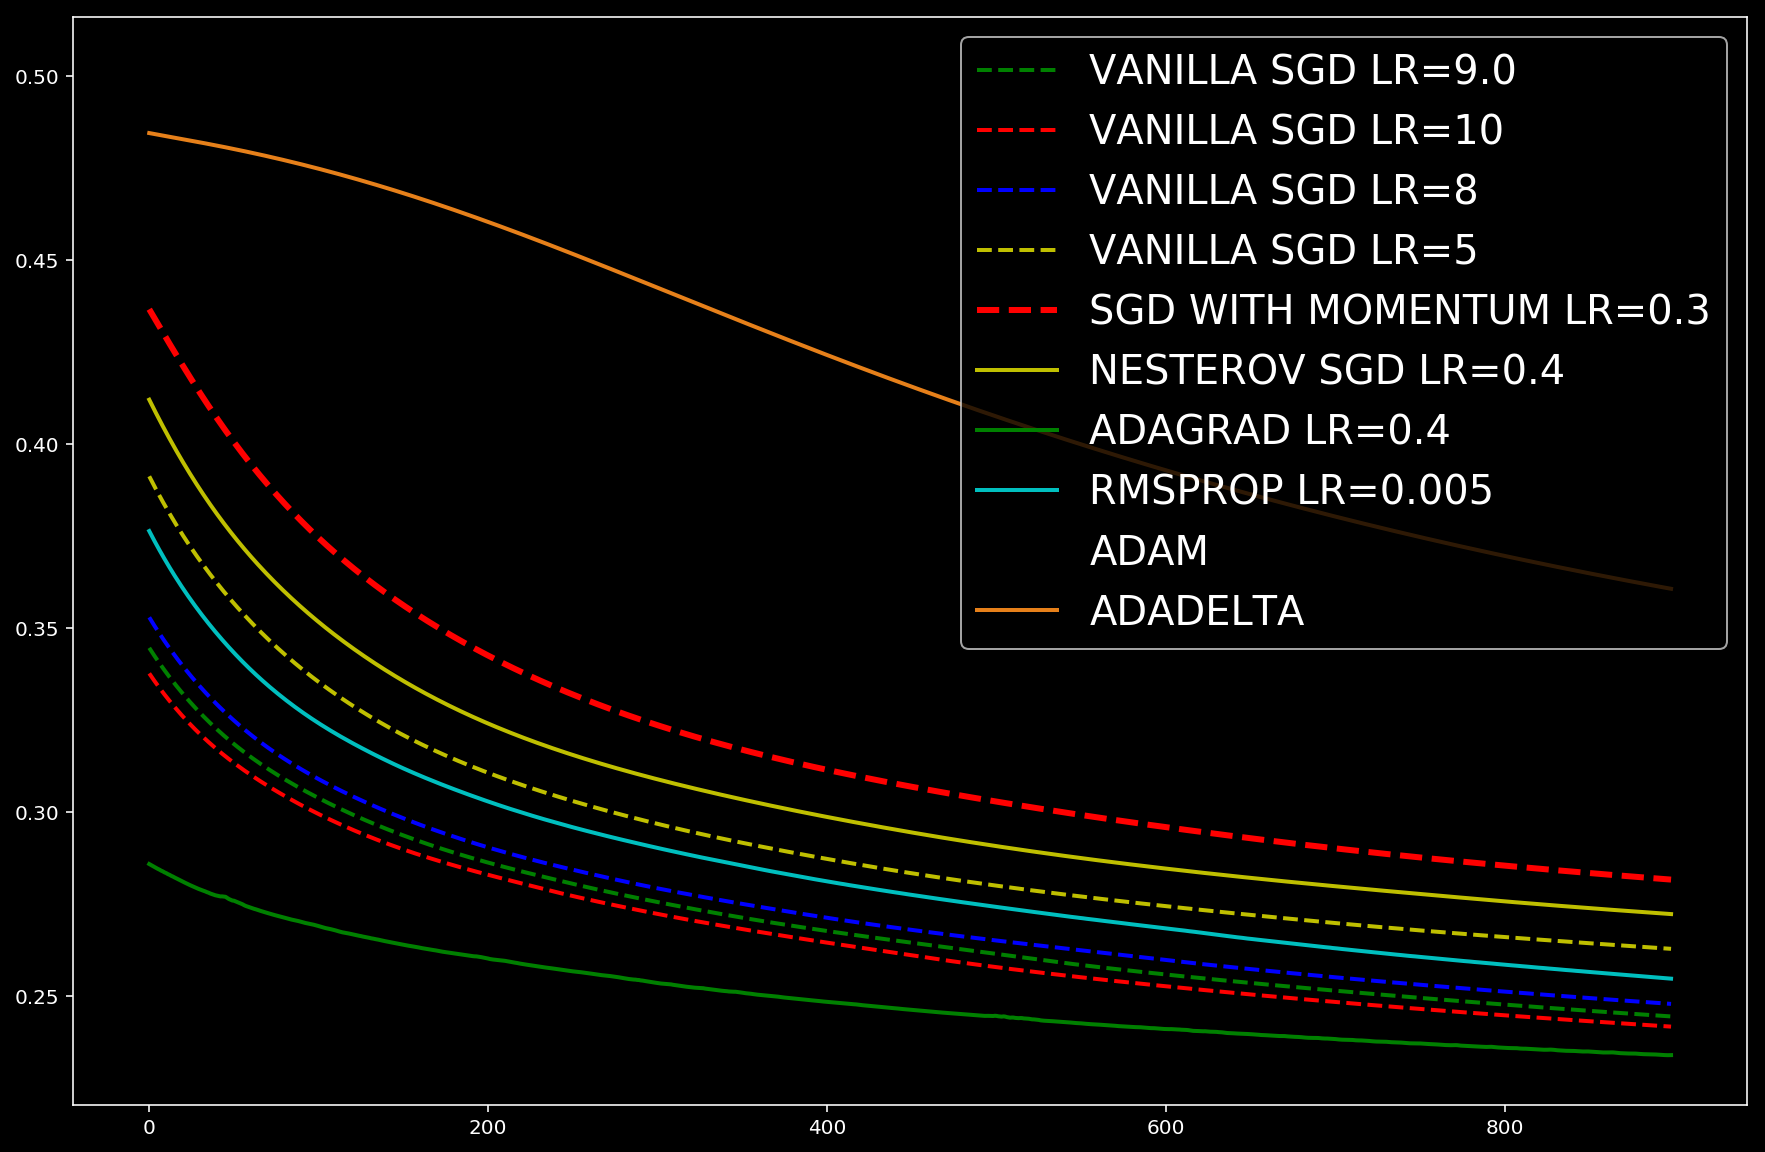

In [26]:
dae.plot_loss_histories(100,-1)